In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('/Users/amanda/Desktop/PhD/Conferences/BostonIAIFI2025/Treatment/stroke_bandits/action_reward_context_combined_processed.csv')

# Use XGBoost to allow for missing data

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import xgboost as xgb


In [27]:
# Drop rows with no target
#df = df[df[target].notna()]


# ================================
# Split data into train and test
# ================================
X = df.drop(columns=['ohs6'])
y = df['ohs6']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ================================
# Full model pipeline
# ================================
model = xgb.XGBRegressor(
        tree_method='hist',
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        missing=np.nan,
        random_state=42
    )

# ================================
# Train the model
# ================================
model.fit(X_train, y_train)

# ================================
# Evaluate the model
# ================================
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")
#accuracy = accuracy_score(y_test, np.round(y_pred))
#print(f"Accuracy: {accuracy}")

y_pred_rounded = np.round(y_pred)

# Ensure both arrays are integers
y_pred_rounded = y_pred_rounded.astype(int)
y_test_int = y_test.astype(int)

# Compute boolean mask where the prediction is within ±2 of the true value
within_2 = np.abs(y_pred_rounded - y_test_int) <= 1

# Compute accuracy
accuracy_within_2 = np.mean(within_2)
print(f"Accuracy within ±2 OHS6 point: {accuracy_within_2:.3f}")

# ================================
# Save the trained model (optional)
# ================================
import joblib
joblib.dump(model, "xgb_ohs6_predictor.pkl")

# Later usage:
# model = joblib.load("xgb_ohs6_predictor.pkl")
# y_new = model.predict(new_data[features])

RMSE: 0.278
R²:   0.352
Accuracy within ±2 OHS6 point: 1.000


['xgb_ohs6_predictor.pkl']

(array([ 47.,  92.,   0.,  64.,   0.,  72.,  41.,   0.,  72., 107.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

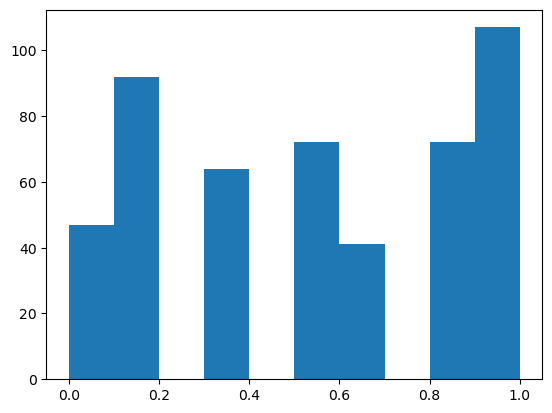

In [32]:
plt.hist(y_test)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predict
y_pred = model.predict(X_test)

# Residuals
residuals = y_test - y_pred
errors = np.abs(residuals)


(array([241.,   0.,   0.,   0., 411.,   0.,   0.,   0.,   0.,   0., 368.,
          0.,   0.,   0.,   0., 370.,   0.,   0.,   0.,   0., 213.,   0.,
          0.,   0.,   0., 309.,   0.,   0.,   0., 560.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

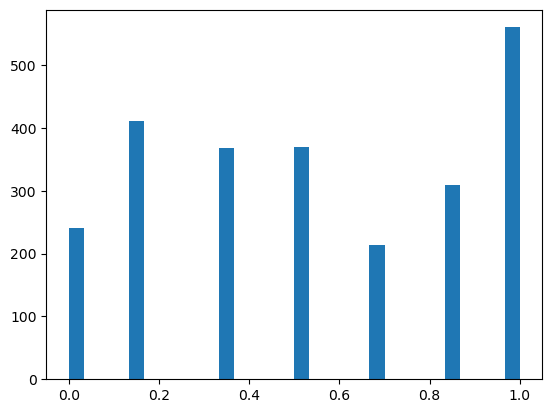

In [29]:
plt.hist(df['ohs6'], bins = 30)

In [30]:
df['ohs6'][df['ohs6'] == 0].unique()

array([0.])

[0, 0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1] ['1', '2', '3', '4', '5', '6']


<Figure size 600x600 with 0 Axes>

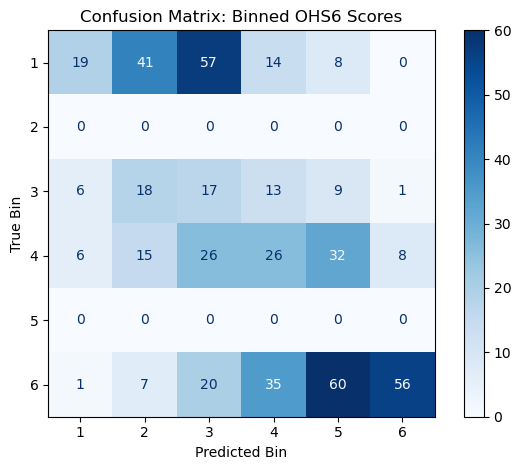

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------------------------------
# 1. BINNING STRATEGY
# Option A: Custom bins (e.g. 0–6, based on OHS definition)
bins = [0, 0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1]

labels = [f'{i}' for i in range(1, 7)]  # Labels for matrix
print(bins, labels)
# Option B: Quantile bins (data-driven)
# quantiles = np.quantile(np.concatenate([y_test, y_pred]), q=np.linspace(0, 1, 6))
# bins = sorted(set(quantiles))
# labels = [f'Q{i}' for i in range(len(bins)-1)]

# --------------------------------------------
# 2. DISCRETIZE y_test and y_pred
y_test_binned = np.digitize(y_test, bins=bins, right=False) - 1
y_pred_binned = np.digitize(y_pred, bins=bins, right=False) - 1

# Clip to valid range in case of out-of-bound values
n_classes = len(labels)
y_test_binned = np.clip(y_test_binned, 0, n_classes - 1)
y_pred_binned = np.clip(y_pred_binned, 0, n_classes - 1)

# --------------------------------------------
# 3. COMPUTE CONFUSION MATRIX
cm = confusion_matrix(y_test_binned, y_pred_binned, labels=range(n_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# --------------------------------------------
# 4. PLOT
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: Binned OHS6 Scores")
plt.xlabel("Predicted Bin")
plt.ylabel("True Bin")
plt.grid(False)
plt.tight_layout()
plt.show()

# Only Deathcode

In [ ]:
# Drop rows with no target
#df = df[df[target].notna()]


# ================================
# Split data into train and test
# ================================
X = df.drop(columns=['ohs6', 'deathcode'])
y = df['deathcode']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ================================
# Full model pipeline
# ================================
model = xgb.XGBRegressor(
        tree_method='hist',
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        missing=np.nan,
        random_state=42
    )

# ================================
# Train the model
# ================================
model.fit(X_train, y_train)

# ================================
# Evaluate the model
# ================================
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")
accuracy = accuracy_score(y_test, np.round(y_pred))
print(f"Accuracy: {accuracy}")

# ================================
# Save the trained model (optional)
# ================================
import joblib
joblib.dump(model, "xgb_deathcode_predictor.pkl")

# Later usage:
#import joblib
# model = joblib.load("xgb_deathcode_predictor.pkl")
# y_new = model.predict(new_data[features])

RMSE: 0.384
R²:   0.293
Accuracy: 0.7984031936127745


['xgb_deathcode_predictor.pkl']

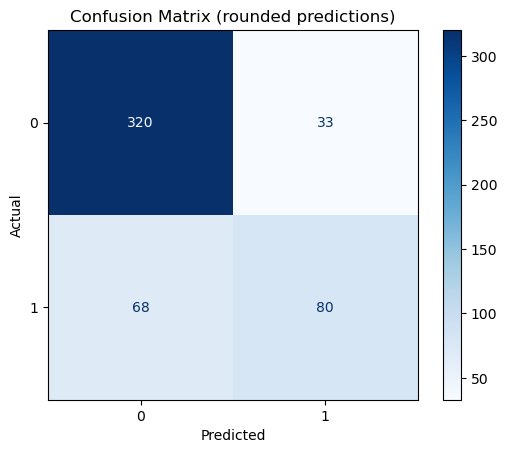

Accuracy (rounded predictions): 0.798


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Round the predicted values to nearest integer for classification-like comparison
y_pred_rounded = np.round(y_pred).astype(int)
y_test_int = y_test.astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test_int, y_pred_rounded)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_int))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (rounded predictions)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Optional: print accuracy again
accuracy = accuracy_score(y_test_int, y_pred_rounded)
print(f"Accuracy (rounded predictions): {accuracy:.3f}")

In [13]:
df.to_csv('processed_data.csv', index=False)